In [3]:
import gc
import time
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import log_loss, accuracy_score
import optuna

# Load features

In [4]:
feat = pd.read_pickle("../feature.pkl")
feat_train = pd.read_pickle("../feature_train.pkl")

In [5]:
feat.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,...,order_fre_ratio_aft_first,prod_mean_reorder_ratio,prod_mean_add_to_cart_order,mean_reorder_ratio,mean_add_to_cart_order,max_order_number,sum_days_since_prior,mean_days_since_prior,count_product_id,unique_count_product_id
0,761287,2928,prior,1,0,1,NaN,29589,2,0,...,0.642857,0.54572,8.586576,0.888889,2.777778,14,734.0,7.489796,100,47
1,761287,2928,prior,1,0,1,NaN,18932,3,0,...,0.071429,0.25,6.428571,0.0,3.0,14,734.0,7.489796,100,47
2,761287,2928,prior,1,0,1,NaN,48075,1,0,...,0.5,0.465228,10.342926,0.857143,3.571429,14,734.0,7.489796,100,47
3,1039920,4640,prior,1,0,3,NaN,40199,1,0,...,0.166667,0.602276,6.884577,0.0,1.0,6,265.0,12.045455,26,18
4,1039920,4640,prior,1,0,3,NaN,38684,4,0,...,0.166667,0.252101,9.918487,0.0,4.0,6,265.0,12.045455,26,18


In [6]:
def convert_dataframe_to_int32_float32(dataframe):
    # Get a list of columns to convert to int32 and float32
    int64_columns = dataframe.select_dtypes(include=['Int64']).columns
    float64_columns = dataframe.select_dtypes(include=['float64']).columns
    
    # Convert the selected columns to int32 and float32
    dataframe[int64_columns] = dataframe[int64_columns].astype('float32')
    dataframe[float64_columns] = dataframe[float64_columns].astype('float32')
    
    return dataframe

In [7]:
feat = convert_dataframe_to_int32_float32(feat)
feat_train = convert_dataframe_to_int32_float32(feat_train)

In [8]:
feat.drop(columns='product_order_ratio', inplace=True)
feat_train.drop(columns='product_order_ratio', inplace=True)

In [9]:
df = feat_train[feat_train['eval_set']=='prior']

In [10]:
test = feat[feat['eval_set']=='train']

In [11]:
pred = feat[feat['eval_set']=='test']

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32640697
Data columns (total 24 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   order_id                     float32
 1   user_id                      float32
 2   eval_set                     object 
 3   order_number                 float32
 4   order_dow                    float32
 5   order_hour_of_day            float32
 6   days_since_prior_order       float32
 7   product_id                   float32
 8   add_to_cart_order            float32
 9   reordered                    float32
 10  one_order_freq               float32
 11  total_bought_freq            float32
 12  item_cust_freq               float32
 13  times_last5                  float32
 14  order_fre_ratio_aft_first    float32
 15  prod_mean_reorder_ratio      float32
 16  prod_mean_add_to_cart_order  float32
 17  mean_reorder_ratio           float32
 18  mean_add_to_cart_order       float32
 19

In [119]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 788 to 33893866
Data columns (total 24 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   order_id                     1384617 non-null  Int64  
 1   user_id                      1384617 non-null  Int64  
 2   eval_set                     1384617 non-null  object 
 3   order_number                 1384617 non-null  Int64  
 4   order_dow                    1384617 non-null  Int64  
 5   order_hour_of_day            1384617 non-null  Int64  
 6   days_since_prior_order       1384617 non-null  float64
 7   product_id                   1384617 non-null  Int64  
 8   add_to_cart_order            1384617 non-null  Int64  
 9   reordered                    1384617 non-null  Int64  
 10  one_order_freq               1384570 non-null  float64
 11  total_bought_freq            828824 non-null   float64
 12  item_cust_freq               1384608 no

In [21]:
df.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)

C:\Users\HEN1\miniconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [121]:
df.dtypes

order_number                     Int64
order_dow                        Int64
order_hour_of_day                Int64
days_since_prior_order         float64
add_to_cart_order                Int64
reordered                        Int64
one_order_freq                 float64
total_bought_freq              float64
item_cust_freq                 float64
times_last5                    float64
order_fre_ratio_aft_first      Float64
prod_mean_reorder_ratio        Float64
prod_mean_add_to_cart_order    Float64
mean_reorder_ratio             Float64
mean_add_to_cart_order         Float64
max_order_number                 Int64
sum_days_since_prior           float64
mean_days_since_prior          float64
count_product_id                 int64
unique_count_product_id          int64
dtype: object

In [122]:
df.isna().sum()

order_number                          0
order_dow                             0
order_hour_of_day                     0
days_since_prior_order          2078068
add_to_cart_order                     0
reordered                             0
one_order_freq                      637
total_bought_freq                     0
item_cust_freq                        0
times_last5                    14347235
order_fre_ratio_aft_first             0
prod_mean_reorder_ratio               0
prod_mean_add_to_cart_order           0
mean_reorder_ratio                    0
mean_add_to_cart_order                0
max_order_number                      0
sum_days_since_prior                  0
mean_days_since_prior                 0
count_product_id                      0
unique_count_product_id               0
dtype: int64

# Model

In [22]:
X_train, X_val, y_train, y_val = train_test_split(df.drop('reordered', axis=1), df.reordered,
                                                    test_size=0.9, random_state=42)

In [15]:
# Define the number of boosting rounds
num_round = 500


In [74]:
# Define your XGBClassifier with the same parameters
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric=["logloss", "map"],
    learning_rate=0.1,
    max_depth=6,
    min_child_weight=10,
    gamma=0.70,
    subsample=0.76,
    colsample_bytree=0.95,
    reg_alpha=2e-05, 
    reg_lambda=10,
    n_estimators=num_round
)

# Train the model directly with XGBClassifier
xgb_model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric=["logloss"], eval_set=[(X_train, y_train), (X_val, y_val)], verbose=10)

C:\Users\HEN1\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.63132	validation_1-logloss:0.63982
[10]	validation_0-logloss:0.34261	validation_1-logloss:0.34447
[20]	validation_0-logloss:0.26611	validation_1-logloss:0.26583
[30]	validation_0-logloss:0.23688	validation_1-logloss:0.23714
[40]	validation_0-logloss:0.22095	validation_1-logloss:0.22046
[50]	validation_0-logloss:0.21096	validation_1-logloss:0.21016
[60]	validation_0-logloss:0.20144	validation_1-logloss:0.20114
[70]	validation_0-logloss:0.19292	validation_1-logloss:0.19276
[80]	validation_0-logloss:0.18480	validation_1-logloss:0.18470
[90]	validation_0-logloss:0.17788	validation_1-logloss:0.17781
[99]	validation_0-logloss:0.17213	validation_1-logloss:0.17206


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.95,
              enable_categorical=False, eval_metric=['logloss', 'map'],
              gamma=0.7, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=10, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=2e-05, reg_lambda=10, scale_pos_weight=1,
              subsample=0.76, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [75]:
# Make predictions on the validation set
y_pred = xgb_model.predict(X_val)
prediction = (y_pred > 0.5).astype(int)


In [76]:
y_pred.shape

(29191041,)

In [77]:
# Calculate log loss on the validation set
logloss = log_loss(y_val, prediction)
accuracy = accuracy_score(y_val, prediction)
print(f'Accuracy: {accuracy:.2f}')
print(f"Log Loss on Validation Set: {logloss}")

Accuracy: 0.93
Log Loss on Validation Set: 2.4893237479863535


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

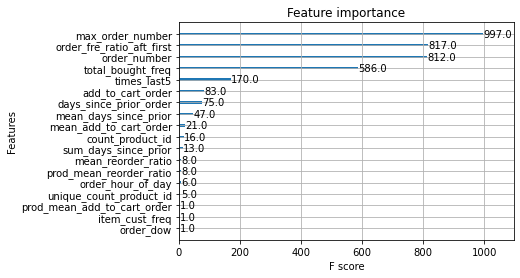

In [78]:
xgb.plot_importance(xgb_model)

# Hyperparameter optimization using optuna

In [19]:
def objective(trial):
    # Define the hyperparameters you want to optimize
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_float('gamma', 0, 1),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-5, 1e-2),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 100),
        'n_estimators': num_round
    }

    # Create and train the XGBoost model with the given hyperparameters
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric=["logloss"], eval_set=[(X_train, y_train), (X_val, y_val)], verbose=10)

    # Predict on the validation set
    y_pred = model.predict_proba(X_val)[:, 1]

    # Calculate log loss as the metric to optimize
    logloss = log_loss(y_val, y_pred)
    return logloss

## Study

In [23]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

[I 2023-10-16 23:23:13,445] A new study created in memory with name: no-name-307888bb-f4e2-456d-a049-32979dd7a1b4
C:\Users\HEN1\miniconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[0]	validation_0-logloss:0.60275	validation_1-logloss:0.59945


[W 2023-10-16 23:23:33,803] Trial 0 failed with parameters: {'learning_rate': 0.150799549032928, 'max_depth': 8, 'min_child_weight': 7, 'gamma': 0.12186535184420422, 'subsample': 0.8111451790953119, 'colsample_bytree': 0.5657307619872771, 'reg_alpha': 0.00011872327301568663, 'reg_lambda': 87.0513048245816} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\HEN1\miniconda3\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\HEN1\AppData\Local\Temp/ipykernel_3276/2278542277.py", line 19, in objective
    model.fit(X_train, y_train, early_stopping_rounds=50, eval_metric=["logloss"], eval_set=[(X_train, y_train), (X_val, y_val)], verbose=10)
  File "C:\Users\HEN1\miniconda3\lib\site-packages\xgboost\core.py", line 506, in inner_f
    return f(**kwargs)
  File "C:\Users\HEN1\miniconda3\lib\site-packages\xgboost\sklearn.py", line 1250, in fit
    self._Booster = train(
 

KeyboardInterrupt: 

In [ ]:
best_params = study.best_params
best_logloss = study.best_value

print("Best Hyperparameters:", best_params)
print("Best Log Loss:", best_logloss)

## Create test set

In [80]:
test.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)

C:\Users\HEN1\miniconda3\lib\site-packages\pandas\core\frame.py:4901: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [88]:
test.shape[0]

1384617

In [82]:
X_test = test.drop('reordered', axis=1)
y_test = test.reordered

In [83]:
# Make predictions on the validation set
test_pred = xgb_model.predict(X_test)
test_prediction = (test_pred > 0.5).astype(int)

In [87]:
len(test_prediction)

1384617

In [89]:
# Calculate log loss on the validation set
logloss = log_loss(y_test, test_prediction)
accuracy = accuracy_score(y_test, test_prediction)
print(f'Accuracy: {accuracy:.2f}')
print(f"Log Loss on Validation Set: {logloss}")

Accuracy: 0.83
Log Loss on Validation Set: 6.251333865704046
